In [1]:
#連結雲端
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# 讀取數據
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_bids = pd.read_csv('/content/drive/My Drive/bids.csv')

# 計算每個競標者的競標數量、競標項目的獨特數量、設備的獨特數量、商品的獨特數量、國家的獨特數量
num_bids_per_bidder = df_bids.groupby('bidder_id').size()
num_auctions_per_bidder = df_bids.groupby('bidder_id')['auction'].nunique()
num_devices_per_bidder = df_bids.groupby('bidder_id')['device'].nunique()
num_merchandise_per_bidder = df_bids.groupby('bidder_id')['merchandise'].nunique()
num_countries_per_bidder = df_bids.groupby('bidder_id')['country'].nunique()

# 創建一個新的 DataFrame 來儲存特徵
df_features = pd.DataFrame({
    'num_bids_per_bidder': num_bids_per_bidder,
    'num_auctions_per_bidder': num_auctions_per_bidder,
    'num_devices_per_bidder': num_devices_per_bidder,
    'num_merchandise_per_bidder': num_merchandise_per_bidder,
    'num_countries_per_bidder': num_countries_per_bidder,
})

# 重置 DataFrame 的索引
df_features.reset_index(inplace=True)

# 將特徵合併到訓練集和測試集
df_train = pd.merge(df_train, df_features, on='bidder_id', how='left')
df_test = pd.merge(df_test, df_features, on='bidder_id', how='left')

# 將缺失的值填充為 0
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

# 創建特徵（X）和目標變量（y）
X_train = df_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'])
y_train = df_train['outcome']

# 初始化模型
# 注意：我們使用的 k-近鄰模型中 k 值為 3，這個參數可以進行調整以優化模型性能
model = KNeighborsClassifier(n_neighbors=3)


# 在整個訓練集上訓練模型
model.fit(X_train, y_train)

# 創建測試集的特徵
X_test = df_test.drop(columns=['bidder_id', 'payment_account', 'address'])

# 預測測試集的概率
y_test_proba = model.predict_proba(X_test)[:, 1]

# 創建一個提交結果的 DataFrame
df_submission = df_test[['bidder_id']].copy()
df_submission['prediction'] = y_test_proba

# 將提交結果寫入 CSV 文件
df_submission.to_csv('KNN.csv', index=False)

print("預測結果已保存到 'KNN.csv'")


預測結果已保存到 'KNN.csv'


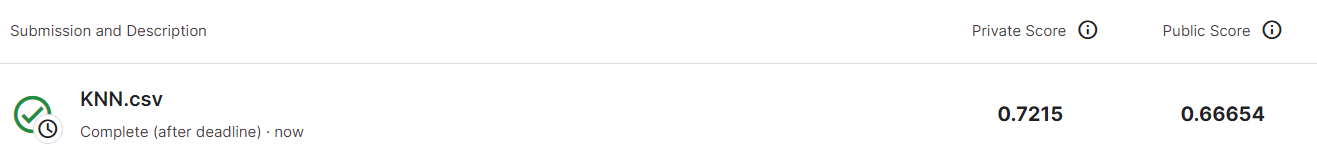

同樣的特徵下，KNN模型得出的結果比Logistic_Regression模型來的好

推測導致此結果可能的原因為:

* 非線性關係：KNN 是一種非參數模型，它不假設特徵與目標之間有線性或其他特定的數學關係。因此，如果數據中存在非線性關係，KNN 可能會表現得更好。相反，羅吉斯迴歸是一種參數模型，它假設特徵與 log odds 的目標之間存在線性關係。

* 複雜的決策邊界：KNN 通過考慮最近的觀察結果來進行預測，這使得它能夠捕捉到複雜的決策邊界。如果數據中的決策邊界很複雜，那麼 KNN 可能會有更好的性能。

* 數據的分布：如果數據的分布比較特殊，例如，在某些區域中，一種類別的數據點比其他類別的數據點更密集，那麼 KNN 可能會有更好的表現。